In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit

In [2]:
# --- 1. Load and Merge Data ---

# Load data
train_transaction = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_identity.csv')
# train_transaction = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
# train_identity = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [3]:
# 1. Create a UID to track "users" across time
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['addr1'].astype(str)

# 2. Transaction Amount relative to User Average
# Does this user usually spend $10 but is now spending $1000?
train_df['uid_Amt_mean'] = train_df.groupby(['uid'])['TransactionAmt'].transform('mean')
train_df['uid_Amt_std'] = train_df.groupby(['uid'])['TransactionAmt'].transform('std')
train_df['Amt_to_mean_ratio'] = train_df['TransactionAmt'] / train_df['uid_Amt_mean']

# 3. Time Engineering
# Fraud often peaks at 3 AM or on weekends.
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['day_of_week'] = (train_df['TransactionDT'] // (3600 * 24)) % 7

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [4]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [5]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [6]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [7]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

--- Top 100 Features Selected ---
['V258', 'C1', 'C14', 'card2', 'D2', 'C13', 'uid_Amt_std', 'uid', 'uid_Amt_mean', 'V317']


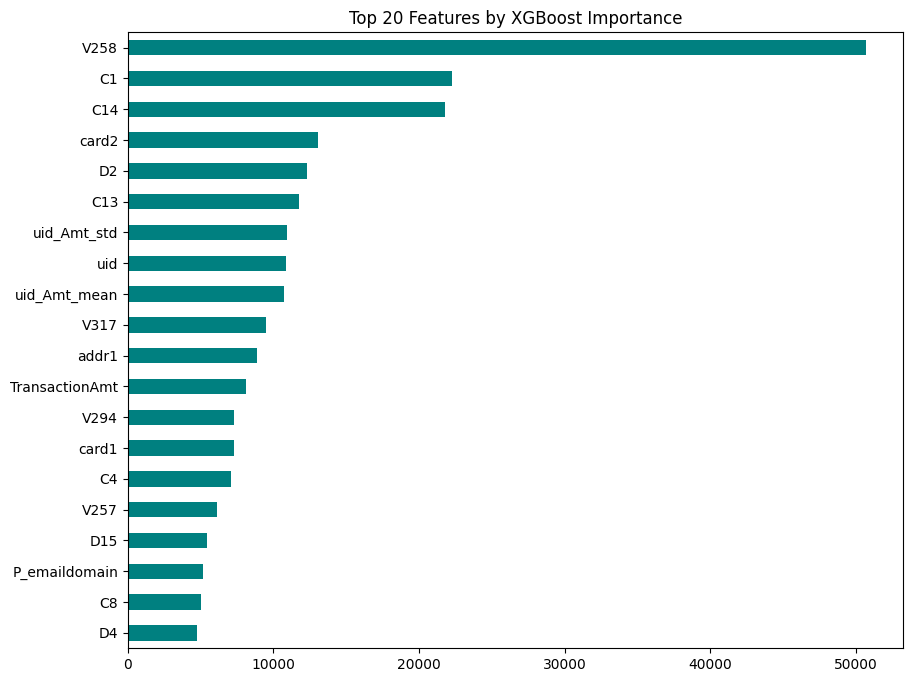

In [8]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 100
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [9]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

# After you get best_features from XGBoost importance:
manual_features = ['Amt_to_mean_ratio', 'hour', 'day_of_week']

for feat in manual_features:
    if feat not in best_features:
        best_features.append(feat)

# Now run your loop that splits into FINAL_CAT_COLS and FINAL_NUM_COLS
# ... (your existing loop) ...

# Verify they are in the list:
print(f"Is uid_count in numerical list? {'uid_count' in FINAL_NUM_COLS}")

# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 29
 - Numerical (Scaled):       71
--------------------------------
Is uid_count in numerical list? False


In [16]:

# 1. Setup copies
X_lgb_train = X_train_ready.copy()
X_lgb_val   = X_val_ready.copy()
X_lgb_test  = X_test_ready.copy()

# 2. Categorical Prep
# LightGBM handles strings if we convert them to the 'category' dtype
for col in FINAL_CAT_COLS:
    X_lgb_train[col] = X_lgb_train[col].astype('category')
    X_lgb_val[col]   = X_lgb_val[col].astype('category')
    X_lgb_test[col]  = X_lgb_test[col].astype('category')

print("✅ Data Ready for LightGBM.")

✅ Data Ready for LightGBM.


In [18]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [ ]:
# 1. Initialize the model
lgb_clf = lgb.LGBMClassifier(
    n_estimators=5000,        # High limit for Early Stopping
    learning_rate=0.01,       # Slow learning for stability
    num_leaves=256,           # Large number of leaves for complex fraud patterns
    max_depth=-13,             # Let leaves decide depth
    min_child_samples=20,     # Prevent overfitting on tiny groups
    feature_fraction=0.8,     # Like colsample_bytree
    bagging_fraction=0.8,     # Like subsample
    bagging_freq=5,           # Perform bagging every 5 iterations
    scale_pos_weight=27.43,   # Your fraud ratio
    objective='binary',
    metric='auc',
    random_state=42,
    min_child_samples=79,
    boosting_type="gbdt",
    req_alpha=0.3,
    req_lambda=0.3,
    colsample_bytree=0.9,
    n_jobs=-1,
    verbose=-1
)

# 2. Train with Early Stopping
# Note: In newer LightGBM, callbacks are used for early stopping
from lightgbm import early_stopping, log_evaluation

print("🚀 Training LightGBM...")
lgb_clf.fit(
    X_lgb_train, y_train,
    eval_set=[(X_lgb_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

🚀 Training LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.908597
[200]	valid_0's auc: 0.911796
[300]	valid_0's auc: 0.916262
[400]	valid_0's auc: 0.91923
[500]	valid_0's auc: 0.921642
[600]	valid_0's auc: 0.923362
[700]	valid_0's auc: 0.924119
[800]	valid_0's auc: 0.924743
[900]	valid_0's auc: 0.925433
[1000]	valid_0's auc: 0.925723
[1100]	valid_0's auc: 0.926022
[1200]	valid_0's auc: 0.926104
[1300]	valid_0's auc: 0.9265
[1400]	valid_0's auc: 0.92633
Early stopping, best iteration is:
[1302]	valid_0's auc: 0.926503


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.01, metric='auc', n_estimators=5000, n_jobs=-1,
               num_leaves=256, objective='binary', random_state=42,
               scale_pos_weight=27.43, verbose=-1)

In [15]:
print("------------------------------------------------")
print("Evaluating XGBoost on TEST Set...")

# 1. Predict (Probabilities)
lgb_preds = lgb_clf.predict_proba(X_lgb_test)[:, 1]

# 2. Score
lgb_auc = roc_auc_score(y_test, lgb_preds)

print(f"🏆 XGBoost FINAL TEST ROC-AUC: {lgb_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating XGBoost on TEST Set...
🏆 XGBoost FINAL TEST ROC-AUC: 0.89526
------------------------------------------------
